Test porfolio optimization and diversification calculations

In [29]:
import pandas as pd
import datetime
import numpy as np
import pickle
import sklearn
import networkx as nx
import tqdm
import matplotlib.pyplot as plt

from sklearn.covariance import GraphicalLassoCV, graphical_lasso, GraphicalLasso
from sklearn.preprocessing import StandardScaler
from statsmodels.distributions.empirical_distribution import ECDF
import scipy.integrate as integrate

# add path to other folders, to import
import sys, os
sys.path.append(os.path.abspath(".."))
from util import fetch_raw_data

In [3]:
from rpy2.robjects.packages import importr
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()
spectralGraphTopology = importr('spectralGraphTopology')
igraph = importr('igraph')
fingraph = importr('fingraph')
fitHeavyTail = importr('fitHeavyTail')
huge = importr('huge')


Unable to determine R library path: Command '('C:\\PROGRA~1\\R\\R-41~1.3\\bin\\Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 1.


Change huge package

change huge package

In [46]:
robjects.r('''

library(spectralGraphTopology)

#' @export
#' @import spectralGraphTopology
learn_regular_heavytail_graph <- function(X,
                                          heavy_type = "gaussian", nu = NULL,
                                          w0 = "naive", d = 1,
                                          rho = 1, update_rho = TRUE, maxiter = 10000, reltol = 1e-5,
                                          verbose = TRUE) {
  X <- as.matrix(X)
  # number of nodes
  p <- ncol(X)
  # number of observations
  n <- nrow(X)
  LstarSq <- vector(mode = "list", length = n)
  for (i in 1:n)
    LstarSq[[i]] <- Lstar(X[i, ] %*% t(X[i, ])) / (n-1)
  # w-initialization
  w <- spectralGraphTopology:::w_init(w0, MASS::ginv(cor(X)))
  A0 <- A(w)
  A0 <- A0 / rowSums(A0)
  w <- spectralGraphTopology:::Ainv(A0)
  J <- matrix(1, p, p) / p
  # Theta-initilization
  Lw <- L(w)
  Theta <- Lw
  Y <- matrix(0, p, p)
  y <- rep(0, p)
  # ADMM constants
  mu <- 2
  tau <- 2
  # residual vectors
  primal_lap_residual <- c()
  primal_deg_residual <- c()
  dual_residual <- c()
  # augmented lagrangian vector
  lagrangian <- c()
  if (verbose)
    pb <- progress::progress_bar$new(format = "<:bar> :current/:total  eta: :eta",
                                     total = maxiter, clear = FALSE, width = 80)
  elapsed_time <- c()
  start_time <- proc.time()[3]
  for (i in 1:maxiter) {
    # update w
    LstarLw <- Lstar(Lw)
    DstarDw <- Dstar(diag(Lw))
    LstarSweighted <- rep(0, .5*p*(p-1))
    if (heavy_type == "student") {
      for (q in 1:n)
        LstarSweighted <- LstarSweighted + LstarSq[[q]] * compute_student_weights(w, LstarSq[[q]], p, nu)
    } else if(heavy_type == "gaussian") {
      for (q in 1:n)
        LstarSweighted <- LstarSweighted + LstarSq[[q]]
    }
    grad <- LstarSweighted - Lstar(rho * Theta + Y) + Dstar(y - rho * d) + rho * (LstarLw + DstarDw)
    eta <- 1 / (2*rho * (2*p - 1))
    wi <- w - eta * grad
    wi[wi < 0] <- 0
    Lwi <- L(wi)
    # update Theta
    eig <- eigen(rho * (Lwi + J) - Y, symmetric = TRUE)
    V <- eig$vectors
    gamma <- eig$values
    Thetai <- V %*% diag((gamma + sqrt(gamma^2 + 4 * rho)) / (2 * rho)) %*% t(V) - J
    # update Y
    R1 <- Thetai - Lwi
    Y <- Y + rho * R1
    # update y
    R2 <- diag(Lwi) - d
    #y <- y + rho * R2
    # compute primal, dual residuals, & lagrangian
    primal_lap_residual <- c(primal_lap_residual, norm(R1, "F"))
    primal_deg_residual <- c(primal_deg_residual, norm(R2, "2"))
    dual_residual <- c(dual_residual, rho*norm(Lstar(Theta - Thetai), "2"))
    lagrangian <- c(lagrangian, compute_augmented_lagrangian_ht(wi, LstarSq, Thetai, J, Y, y, d, heavy_type, n, p, rho, nu))
    # update rho
    if (update_rho) {
      s <- rho * norm(Lstar(Theta - Thetai), "2")
      r <- norm(R1, "F")
      if (r > mu * s)
        rho <- rho * tau
      else if (s > mu * r)
        rho <- rho / tau
    }
    if (verbose)
      pb$tick()
    has_converged <- (norm(Lw - Lwi, 'F') / norm(Lw, 'F') < reltol) && (i > 1)
    elapsed_time <- c(elapsed_time, proc.time()[3] - start_time)
    if (has_converged)
      break
    w <- wi
    Lw <- Lwi
    Theta <- Thetai
  }
  results <- list(laplacian = L(wi),
                  adjacency = A(wi),
                  theta = Thetai,
                  maxiter = i,
                  convergence = has_converged,
                  primal_lap_residual = primal_lap_residual,
                  primal_deg_residual = primal_deg_residual,
                  dual_residual = dual_residual,
                  lagrangian = lagrangian,
                  elapsed_time = elapsed_time)
  return(results)
}

compute_student_weights <- function(w, LstarSq, p, nu) {
  return((p + nu) / (sum(w * LstarSq) + nu))
}

compute_augmented_lagrangian_ht <- function(w, LstarSq, Theta, J, Y, y, d, heavy_type, n, p, rho, nu) {
  eig <- eigen(Theta + J, symmetric = TRUE, only.values = TRUE)$values
  Lw <- L(w)
  Dw <- diag(Lw)
  u_func <- 0
  if (heavy_type == "student") {
    for (q in 1:n)
      u_func <- u_func + (p + nu) * log(1 + n * sum(w * LstarSq[[q]]) / nu)
  } else if (heavy_type == "gaussian"){
    for (q in 1:n)
      u_func <- u_func + sum(n * w * LstarSq[[q]])
  }
  u_func <- u_func / n
  return(u_func - sum(log(eig)) + sum(y * (Dw - d)) + sum(diag(Y %*% (Theta - Lw)))
         + .5 * rho * (norm(Dw - d, "2")^2 + norm(Lw - Theta, "F")^2))
}

''')



robjects.r('''

library(huge)

huge.glasso = function(x, scale = FALSE, lambda = NULL, lambda.min.ratio = NULL, nlambda = NULL, scr = NULL, cov.output = FALSE, verbose = TRUE){

  gcinfo(FALSE)
  n = nrow(x)
  d = ncol(x)
  cov.input = isSymmetric(x)
  if(cov.input)
  {
    if(verbose) cat("The input is identified as the covariance matrix.\n")
    S = x
  }
  else
  {
    if(scale){
      print("SCALE")
      x = scale(x)
    S = cor(x)
    }else{
    print("my_method")
    S = cov(x)
    }

  }
  rm(x)
  gc()
  if(is.null(scr)) scr = FALSE
  if(!is.null(lambda)) nlambda = length(lambda)
  if(is.null(lambda))
  {
    if(is.null(nlambda))
      nlambda = 10
    if(is.null(lambda.min.ratio))
      lambda.min.ratio = 0.1
    lambda.max = max(max(S-diag(d)),-min(S-diag(d)))
    lambda.min = lambda.min.ratio*lambda.max
    lambda = exp(seq(log(lambda.max), log(lambda.min), length = nlambda))
  }

  fit = .Call("_huge_hugeglasso",S,lambda,scr,verbose,cov.output,PACKAGE="huge")

  fit$scr = scr
  fit$lambda = lambda
  fit$cov.input = cov.input
  fit$cov.output = cov.output

  rm(S)
  gc()
  if(verbose){
       cat("\nConducting the graphical lasso (glasso)....done.                                          \r")
       cat("\n")
      flush.console()
  }
  return(fit)
}

huge = function(x, scale = scale, lambda = NULL, nlambda = NULL, lambda.min.ratio = NULL, method = "mb", scr = NULL, scr.num = NULL, cov.output = FALSE, sym = "or", verbose = TRUE)
{
	gcinfo(FALSE)
	est = list()
	est$method = method

	if(method == "ct")
	{
		fit = huge.ct(x, nlambda = nlambda, lambda.min.ratio = lambda.min.ratio, lambda = lambda, verbose = verbose)
		est$path = fit$path
		est$lambda = fit$lambda
		est$sparsity = fit$sparsity
		est$cov.input = fit$cov.input
		rm(fit)
		gc()
	}

	if(method == "mb")
	{
		fit = huge.mb(x, lambda = lambda, nlambda = nlambda, lambda.min.ratio = lambda.min.ratio, scr = scr, scr.num = scr.num, sym = sym, verbose = verbose)
		est$path = fit$path
		est$beta = fit$beta
		est$lambda = fit$lambda
		est$sparsity = fit$sparsity
		est$df = fit$df
		est$idx_mat = fit$idx_mat
		est$sym = sym
		est$scr = fit$scr
		est$cov.input = fit$cov.input
		rm(fit,sym)
		gc()
	}


	if(method == "glasso")
	{
		fit = huge.glasso(x, scale = scale, nlambda = nlambda, lambda.min.ratio = lambda.min.ratio, lambda = lambda, scr = scr, cov.output = cov.output, verbose = verbose)
		est$path = fit$path
		est$lambda = fit$lambda
		est$icov = fit$icov
		est$df = fit$df
		est$sparsity = fit$sparsity
		est$loglik = fit$loglik
		if(cov.output)
			est$cov = fit$cov
		est$cov.input = fit$cov.input
		est$cov.output = fit$cov.output
		est$scr = fit$scr
		rm(fit)
		gc()
	}

	if(method == "tiger")
	{
	  fit = huge.tiger(x, lambda = lambda, nlambda = nlambda, lambda.min.ratio = lambda.min.ratio, sym = sym, verbose = verbose)
	  est$path = fit$path
	  est$lambda = fit$lambda
	  est$sparsity = fit$sparsity
	  est$df = fit$df
	  est$idx_mat = fit$idx_mat
	  est$sym = sym
	  est$scr = fit$scr
	  est$cov.input = fit$cov.input
	  est$icov = fit$icov;
	  rm(fit,sym)
	  gc()
	}

	est$data = x

	rm(x,scr,lambda,lambda.min.ratio,nlambda,cov.output,verbose)
	gc()
	class(est) = "huge"
	return(est)
}

my_huge <- function(X, gamma = 0.1, lamda = exp(seq(log(1e-3), log(1e-7), length = 50)),scale = FALSE){

    out.glasso = huge(X, scale = scale, lambda = lamda, method = "glasso")
    return(huge.select(out.glasso, criterion = "ebic",ebic.gamma = 0.1 ))


}



''')

my_huge = robjects.globalenv["my_huge"]

Load data

In [4]:
return_pivot, esg_pivot, sector_classification = fetch_raw_data("C:/Users/User/Code/MMD_Graph_Diversification/")
# esg smoothed stock
with open("../data/tidy/gp_esg_stock_data_frame.pkl", "rb") as input_file:
   gp_esg_stock_data_frame = pickle.load(input_file)


2014-10-01 00:00:00
2022-02-01 00:00:00


diversification functions

In [30]:
def div_ratio(w, cov):
  # numerator is perfect correlation
  # denom is portfolio risk
  return np.inner(w, np.sqrt(np.diag(cov)))/np.sqrt(np.dot(w, cov).dot(w))

def var_div_ratio(w,data, q = 0.95):
  # w weights
  # d = data

  ind_var = []
  for col in range(data.shape[1]):
      ind_var.append(np.quantile(-data[:,col], q))

  port_var = np.quantile(np.dot(-data, w), q)

  return port_var/np.inner(ind_var,w)

def fix_weight(w:np.array):

    if np.sum(w[w <0]) <-0.3:

        # fix negative
        w[w <0] = 0.3*w[w <0]/np.abs(np.sum(w[w <0]))
        w[w >=0] = 1.3*w[w >=0]/np.abs(np.sum(w[w >=0]))

    return w

def omega(x, level = 0):
  ecdf = ECDF(x)  
  numerator = integrate.quad(lambda x: 1-ecdf(x), level, np.inf, limit = 10000)
  denominator = integrate.quad(ecdf, -np.inf, level, limit = 10000)
  if denominator[0] == 0.0:
    return 10
  else:
    return numerator[0]/denominator[0]

def sharpe(mu, sigma, r_f = 0):

  return (mu-r_f)/sigma

def sortino(mu,x, r_f = 0):

  x_above = x.copy()
  x_above[x_above > r_f] = r_f

  return (mu -r_f)/(np.sqrt(np.mean(x_above ** 2)))

def beta(X_port, X_index):
  return np.cov(X_port,X_index)[0,1]/np.var(X_index)

def treynor(mu, beta, r_f = 0):
  return (mu-r_f)/beta

def portfolio(S,precision_matrix, mu, stock_split_i, type):

  if type == 'uniform':
      w = np.ones(S.shape[1])/S.shape[1]
      mu_p = np.mean(np.dot(stock_split_i, w))
      var_p = np.dot(w,S).dot(w)
  elif type == 'sharpe':
      w = np.dot(precision_matrix, mu)/np.dot(np.ones(S.shape[0]), precision_matrix).dot(mu) 
      w = fix_weight(w)
      mu_p = np.mean(np.dot(stock_split_i, w))
      var_p = np.dot(w,S).dot(w)
  elif type == 'gmv':
      w = np.dot(precision_matrix, np.ones(S.shape[0]))/np.dot(np.ones(S.shape[0]), precision_matrix).dot(np.ones(S.shape[0])) 
      w = fix_weight(w)
      mu_p = np.mean(np.dot(stock_split_i, w))
      var_p = np.dot(w,S).dot(w)


  return w, mu_p, var_p 



Estimate the correlation for some sector using various methods. Look at the weights, diversification for different methods

In [7]:
# esg smoothed stock
gp_esg_stock = pd.read_pickle('../data/tidy/gp_esg_stock_data_frame.pkl')

In [17]:
def get_index(tick):
    """
    Function that takes the sp500 index from yahoo
    """
    
    import requests
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
    # ESG historical data (only changes yearly)
    url_esg = f"https://query1.finance.yahoo.com/v7/finance/spark?symbols={tick}&range=10y&interval=1d&indicators=close&includeTimestamps=false&includePrePost=false&corsDomain=finance.yahoo.com&.tsrc=finance"
    response = requests.get(url_esg, headers=headers)
    if response.ok:
        sp500 = pd.DataFrame({'date':pd.to_datetime(response.json()['spark']['result'][0]['response'][0]['timestamp'], unit= 's'),
                              'price':response.json()['spark']['result'][0]['response'][0]['indicators']['quote'][0]['close']})
    
    else:
        print("Empty data frame")
        sp500 = pd.DataFrame()



    return sp500

sp500 = get_index('^GSPC')
sp500['date'] = pd.to_datetime(sp500['date']).dt.date
sp500['return'] = 1 + sp500['price'].pct_change()
sp500['log_return'] = np.log(sp500['price']).diff()
sp500 = sp500.iloc[:,:].dropna(axis= 0)



In [66]:

sector = 'Industrials'
rolling_window_size = 300
time_i = 300
transform = None#'nonparanormal'
scale = True

if scale:
    lamda = np.exp(np.linspace(start = np.log(1e-1), stop = np.log(1e-4) ,num =80))
else:
    lamda = np.exp(np.linspace(start = np.log(1e-3), stop = np.log(1e-7) ,num =80))


cov_div_list= []
var_div_list= []
sharpe_list = []
omega_list = []
sortino_list = []
beta_list = []
treynor_list = []
dates = []

for time_i in tqdm.tqdm(range(rolling_window_size, rolling_window_size + 100)):


    normal_div_gmv_dict = {}
    var_div_gmv_dict = {}

    assets = np.concatenate([sector_classification[sector] for sector in ['Industrials']])
    current_returns = return_pivot.loc[:,np.isin(return_pivot.columns,assets)].iloc[(time_i - rolling_window_size):time_i]
    all_stocks_in_sector = sector_classification['Industrials']

    stocks_in_sector = current_returns.columns[np.isin(current_returns.columns,all_stocks_in_sector)]
    esg_stocks_in_sector = gp_esg_stock.columns[np.isin(gp_esg_stock.columns,all_stocks_in_sector)]

    stocks_considered = stocks_in_sector.intersection(esg_stocks_in_sector)

    # get esg scores of the stocks for the current iteration
    esg_i = np.array(gp_esg_stock[stocks_considered].iloc[time_i])

    # get snp500 index for current iteration, used in  
    snp500_i = np.array(sp500.loc[np.isin(sp500.date,current_returns.index), 'log_return'])
    # order stocks
    stocks_ordered_i = np.array(stocks_considered[np.argsort(esg_i)])
    stocks_indexes = np.array(range(len(stocks_considered)))
    stocks_index = np.array_split(stocks_indexes, 3)[0]


 

    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()

    stock_split_i = np.array(current_returns)

    if transform is None:
        stock_split_i = np.array(return_pivot[stocks_ordered_i[stocks_index]].iloc[(time_i - rolling_window_size):time_i])
    elif transform == 'nonparanormal':
        stock_split_i =return_pivot[stocks_ordered_i[stocks_index]].iloc[(time_i - rolling_window_size):time_i]
        mu_tmp = np.array(stock_split_i.mean())
        print(mu_tmp)
        S_tmp = np.array(stock_split_i.cov())
        stock_split_i = huge.huge_npn(np.array(stock_split_i) , npn_func="truncation")
        # convert to correct scale again
        stock_split_i = (stock_split_i*np.sqrt(np.diag(S_tmp)) + mu_tmp)
        print(np.mean(stock_split_i, axis=1))
    else:
        raise ValueError(f"No transform called {transform}")

    var = np.diag(np.cov(stock_split_i.T))


    out_select = my_huge(stock_split_i, gamma = 0.01, lamda = lamda, scale = scale)
    out_select = dict(zip(out_select.names, list(out_select)))


    precision_matrix = out_select['opt.icov'].copy()
    S = np.linalg.inv(precision_matrix)
    if scale:
        S = np.dot(np.diag(np.sqrt(var)), S).dot(np.diag(np.sqrt(var)))

    mu = np.mean(stock_split_i, 0)
    port_type = 'sharpe'
    w, mu_p, var_p = portfolio(S, np.linalg.inv(S), mu, np.array(stock_split_i), port_type)
    r_p = np.dot(np.array(stock_split_i),w)
    # print(np.sum(r_p <0))
    cov_div_list.append(div_ratio(w,S))
    var_div_list.append(var_div_ratio(w,np.array(stock_split_i)))
    sharpe_list.append(sharpe(mu_p, np.sqrt(var_p)))
    omega_list.append(omega(r_p))
    sortino_list.append(sortino(mu_p, r_p))

    beta_p = beta(r_p, snp500_i)
    beta_list.append(beta_p)
    treynor_list.append(treynor(mu_p, beta_p))

    dates.append(current_returns.index[-1])

  0%|          | 0/100 [00:00<?, ?it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


  1%|          | 1/100 [00:01<01:42,  1.03s/it]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


  2%|▏         | 2/100 [00:02<01:39,  1.01s/it]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


  3%|▎         | 3/100 [00:03<01:37,  1.01s/it]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


  4%|▍         | 4/100 [00:03<01:34,  1.02it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


  5%|▌         | 5/100 [00:04<01:33,  1.02it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


  6%|▌         | 6/100 [00:05<01:32,  1.02it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


  7%|▋         | 7/100 [00:06<01:31,  1.02it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


  8%|▊         | 8/100 [00:07<01:28,  1.03it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


  9%|▉         | 9/100 [00:08<01:27,  1.04it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 10%|█         | 10/100 [00:09<01:27,  1.03it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 11%|█         | 11/100 [00:10<01:27,  1.02it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 12%|█▏        | 12/100 [00:11<01:27,  1.01it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 13%|█▎        | 13/100 [00:12<01:27,  1.00s/it]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 14%|█▍        | 14/100 [00:13<01:26,  1.01s/it]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 15%|█▌        | 15/100 [00:14<01:24,  1.00it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 16%|█▌        | 16/100 [00:15<01:22,  1.01it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 17%|█▋        | 17/100 [00:16<01:24,  1.01s/it]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 18%|█▊        | 18/100 [00:17<01:23,  1.02s/it]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 19%|█▉        | 19/100 [00:18<01:21,  1.01s/it]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 20%|██        | 20/100 [00:19<01:20,  1.01s/it]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 21%|██        | 21/100 [00:20<01:18,  1.00it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 22%|██▏       | 22/100 [00:21<01:17,  1.01it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 23%|██▎       | 23/100 [00:22<01:15,  1.01it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 24%|██▍       | 24/100 [00:23<01:14,  1.02it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 25%|██▌       | 25/100 [00:24<01:12,  1.04it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 26%|██▌       | 26/100 [00:25<01:10,  1.05it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 27%|██▋       | 27/100 [00:26<01:09,  1.05it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 28%|██▊       | 28/100 [00:27<01:08,  1.05it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 29%|██▉       | 29/100 [00:28<01:07,  1.05it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 30%|███       | 30/100 [00:29<01:06,  1.05it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 31%|███       | 31/100 [00:30<01:07,  1.03it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 32%|███▏      | 32/100 [00:31<01:06,  1.02it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 33%|███▎      | 33/100 [00:32<01:05,  1.02it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 34%|███▍      | 34/100 [00:33<01:04,  1.03it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 35%|███▌      | 35/100 [00:34<01:04,  1.01it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 36%|███▌      | 36/100 [00:35<01:02,  1.02it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 37%|███▋      | 37/100 [00:36<01:01,  1.03it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 38%|███▊      | 38/100 [00:37<01:00,  1.02it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 39%|███▉      | 39/100 [00:38<00:59,  1.02it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 40%|████      | 40/100 [00:39<00:59,  1.01it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 41%|████      | 41/100 [00:40<00:58,  1.02it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 42%|████▏     | 42/100 [00:41<00:56,  1.02it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 43%|████▎     | 43/100 [00:42<00:55,  1.04it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 44%|████▍     | 44/100 [00:43<00:54,  1.04it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 45%|████▌     | 45/100 [00:44<00:53,  1.03it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 46%|████▌     | 46/100 [00:45<00:52,  1.02it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 47%|████▋     | 47/100 [00:46<00:51,  1.02it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 48%|████▊     | 48/100 [00:47<00:50,  1.02it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 49%|████▉     | 49/100 [00:48<00:49,  1.04it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 50%|█████     | 50/100 [00:49<00:48,  1.03it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 51%|█████     | 51/100 [00:49<00:47,  1.04it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 52%|█████▏    | 52/100 [00:50<00:45,  1.05it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 53%|█████▎    | 53/100 [00:51<00:45,  1.04it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 54%|█████▍    | 54/100 [00:52<00:44,  1.04it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 55%|█████▌    | 55/100 [00:53<00:43,  1.03it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 56%|█████▌    | 56/100 [00:54<00:42,  1.02it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 57%|█████▋    | 57/100 [00:55<00:42,  1.02it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 58%|█████▊    | 58/100 [00:56<00:41,  1.02it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 59%|█████▉    | 59/100 [00:57<00:40,  1.01it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 60%|██████    | 60/100 [00:58<00:39,  1.01it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 61%|██████    | 61/100 [00:59<00:39,  1.01s/it]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 62%|██████▏   | 62/100 [01:00<00:38,  1.02s/it]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 63%|██████▎   | 63/100 [01:01<00:37,  1.03s/it]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 64%|██████▍   | 64/100 [01:02<00:37,  1.03s/it]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 65%|██████▌   | 65/100 [01:04<00:35,  1.03s/it]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 66%|██████▌   | 66/100 [01:05<00:34,  1.02s/it]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 67%|██████▋   | 67/100 [01:06<00:33,  1.03s/it]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 68%|██████▊   | 68/100 [01:07<00:32,  1.03s/it]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 69%|██████▉   | 69/100 [01:08<00:31,  1.02s/it]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 70%|███████   | 70/100 [01:09<00:31,  1.06s/it]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 71%|███████   | 71/100 [01:10<00:30,  1.05s/it]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 72%|███████▏  | 72/100 [01:11<00:29,  1.04s/it]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 73%|███████▎  | 73/100 [01:12<00:27,  1.02s/it]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 74%|███████▍  | 74/100 [01:13<00:25,  1.01it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 75%|███████▌  | 75/100 [01:14<00:24,  1.02it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 76%|███████▌  | 76/100 [01:15<00:23,  1.00it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 77%|███████▋  | 77/100 [01:16<00:22,  1.02it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 78%|███████▊  | 78/100 [01:17<00:21,  1.02it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 79%|███████▉  | 79/100 [01:18<00:20,  1.03it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 80%|████████  | 80/100 [01:19<00:19,  1.04it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 81%|████████  | 81/100 [01:19<00:18,  1.04it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 82%|████████▏ | 82/100 [01:20<00:17,  1.05it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 83%|████████▎ | 83/100 [01:21<00:16,  1.05it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 84%|████████▍ | 84/100 [01:22<00:15,  1.05it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 85%|████████▌ | 85/100 [01:23<00:14,  1.04it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 86%|████████▌ | 86/100 [01:24<00:13,  1.05it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 87%|████████▋ | 87/100 [01:25<00:12,  1.04it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 88%|████████▊ | 88/100 [01:26<00:11,  1.04it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 89%|████████▉ | 89/100 [01:27<00:10,  1.04it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 90%|█████████ | 90/100 [01:28<00:09,  1.04it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 91%|█████████ | 91/100 [01:29<00:08,  1.05it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 92%|█████████▏| 92/100 [01:30<00:07,  1.04it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 93%|█████████▎| 93/100 [01:31<00:06,  1.05it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 94%|█████████▍| 94/100 [01:32<00:05,  1.05it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 95%|█████████▌| 95/100 [01:33<00:04,  1.06it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 96%|█████████▌| 96/100 [01:34<00:03,  1.06it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 97%|█████████▋| 97/100 [01:35<00:02,  1.06it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 98%|█████████▊| 98/100 [01:36<00:01,  1.05it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


 99%|█████████▉| 99/100 [01:37<00:00,  1.05it/s]

[1] "SCALE"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 1%2%3%5%6%7%8%9%11%12%13%15%16%17%18%19%21%22%23%25%26%27%28%30%31%32%33%35%36%37%38%40%41%42%43%44%46%47%48%50%51%52%53%55%56%57%58%60%61%62%63%65%66%67%68%70%71%72%73%75%76%77%78%80%81%82%83%85%86%87%88%90%91%92%93%95%96%97%98%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


100%|██████████| 100/100 [01:38<00:00,  1.02it/s]


Text(0.5, 1.0, 'Treynor')

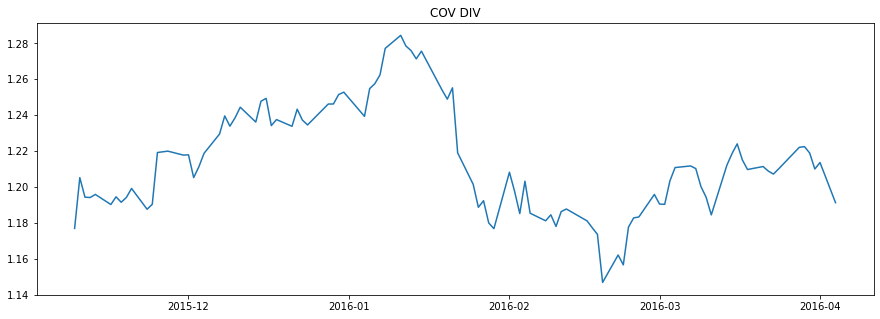

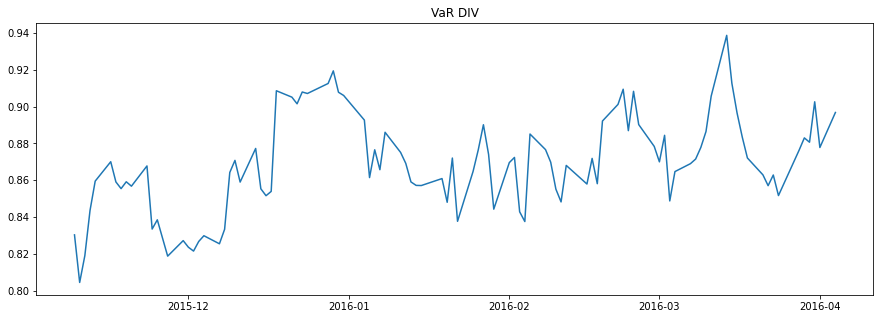

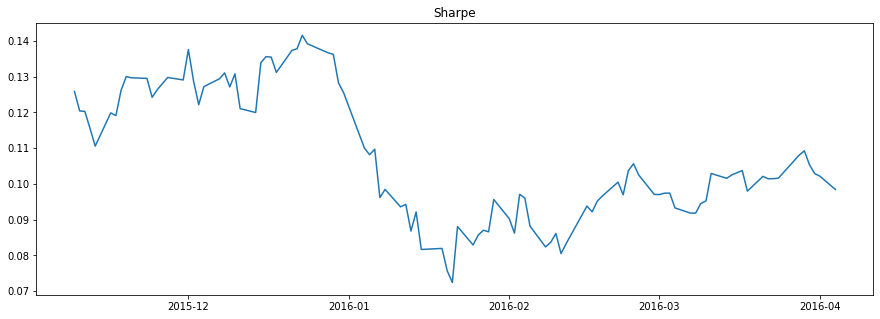

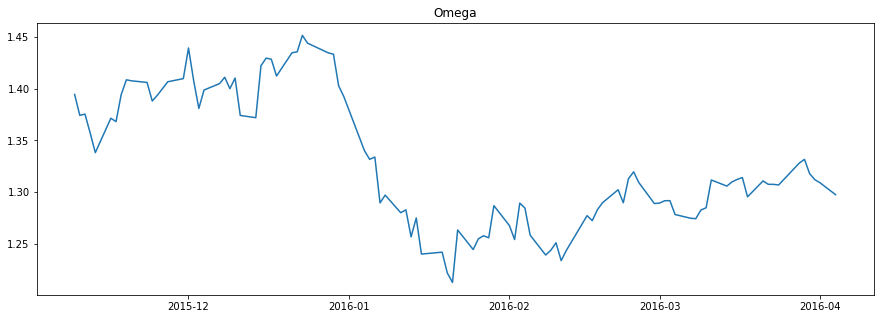

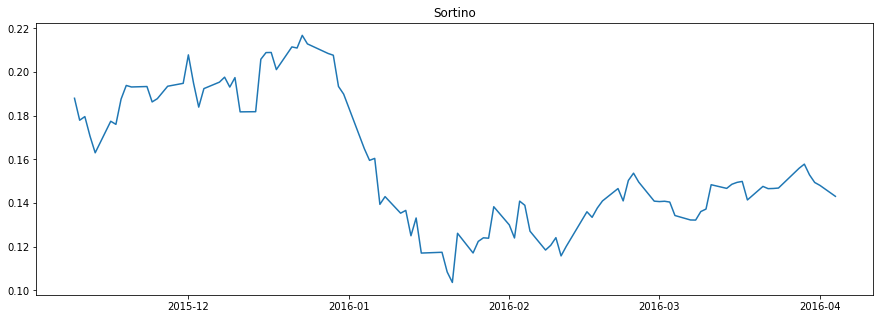

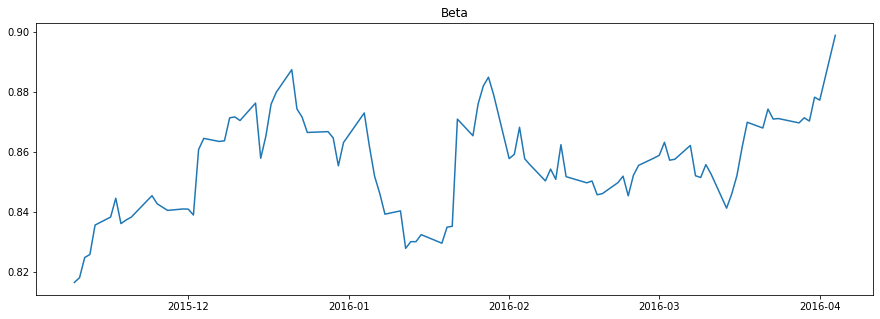

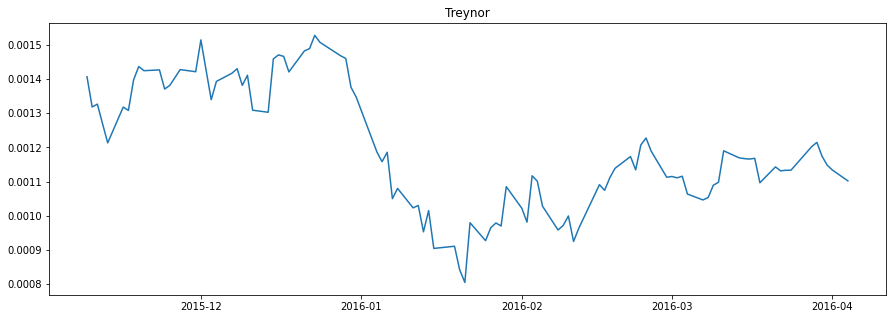

In [67]:
fig, ax = plt.subplots(1,1, figsize = (15,5))
ax.plot(dates, cov_div_list)
ax.set_title('COV DIV')
fig, ax = plt.subplots(1,1, figsize = (15,5))
ax.plot(dates, var_div_list)
ax.set_title('VaR DIV')
fig, ax = plt.subplots(1,1, figsize = (15,5))
ax.plot(dates, sharpe_list)
ax.set_title('Sharpe')
fig, ax = plt.subplots(1,1, figsize = (15,5))
ax.plot(dates, omega_list)
ax.set_title('Omega')
fig, ax = plt.subplots(1,1, figsize = (15,5))
ax.plot(dates, sortino_list)
ax.set_title('Sortino')
fig, ax = plt.subplots(1,1, figsize = (15,5))
ax.plot(dates, beta_list)
ax.set_title('Beta')
fig, ax = plt.subplots(1,1, figsize = (15,5))
ax.plot(dates, treynor_list)
ax.set_title('Treynor')

In [680]:
w_sharpe

array([ 4.14956783e-01,  1.17470039e+00,  5.68231493e-01, -1.13356259e+00,
       -1.11750172e+00,  8.10949263e-01, -9.79755854e-02, -7.56267067e-01,
        4.78883650e-01, -5.64320939e-01, -1.35732704e+00,  2.41309081e+00,
        1.35447262e+00,  4.90899827e-01,  4.55989118e-02, -2.79437068e-01,
        1.67059281e-01, -3.49897215e-03,  1.52222362e+00, -1.25755402e-01,
        2.98870927e-01, -8.18017030e-02,  7.22928030e-01, -2.17320669e+00,
        8.89625209e-02,  3.41327037e-01, -9.04167124e-01,  2.00056270e+00,
       -2.70517169e-02,  1.37608584e+00,  1.76982477e+00, -2.55195554e+00,
        6.67906670e-01,  3.75477359e-01, -1.42100346e+00,  1.04748139e-03,
        3.43062914e-01,  1.57761334e+00, -7.42516176e-01, -1.80084504e+00,
        7.31740065e-01,  9.43278710e-01,  9.21552623e-01, -1.56582229e+00,
        1.80179938e-01, -1.94786269e+00,  5.24001151e-01, -3.77425535e-01,
       -6.15167501e-01,  6.36553570e-01, -1.93122838e-01,  9.61415172e-01,
        1.47605835e-01, -

0.3143374038896427

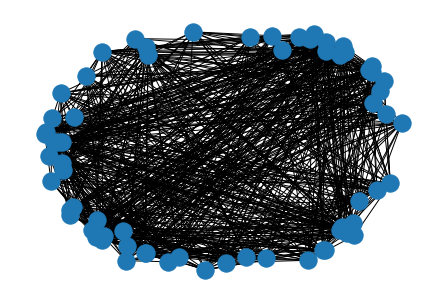

In [760]:
ok = out_select['opt.icov'].copy()
np.fill_diagonal(ok,0)
G = nx.from_numpy_array(ok)
nx.draw(G)
nx.density(G)


In [854]:
mu_tmp = np.array(current_returns.mean())
S = tmp = np.array(current_returns.cov())

In [860]:
X_npn = huge.huge_npn(np.array(current_returns), npn_func="truncation")
X_npn = X_npn*np.diag(S) + mu_tmp

Conducting nonparanormal (npn) transformation via truncated ECDF....done.


(array([11., 17., 29., 42., 50., 51., 42., 29., 17., 12.]),
 array([0.00026408, 0.000306  , 0.00034793, 0.00038985, 0.00043178,
        0.0004737 , 0.00051563, 0.00055755, 0.00059947, 0.0006414 ,
        0.00068332]),
 <BarContainer object of 10 artists>)

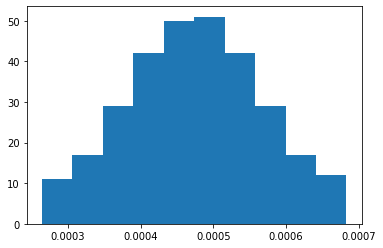

In [861]:
plt.hist(X_npn[:,0])

(array([  2.,   1.,   4.,  11.,  31.,  94., 108.,  38.,   7.,   4.]),
 array([-0.04554511, -0.03786306, -0.03018101, -0.02249896, -0.01481691,
        -0.00713486,  0.00054719,  0.00822924,  0.01591128,  0.02359333,
         0.03127538]),
 <BarContainer object of 10 artists>)

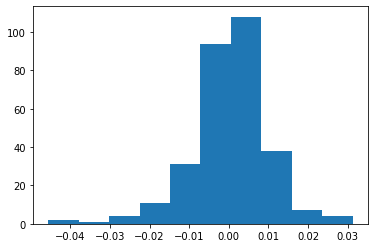

In [862]:
plt.hist(current_returns.iloc[:,0])

In [877]:
np.exp(np.linspace(start = np.log(0.1), stop = np.log(1e-3) ,num =50))

array([0.1       , 0.09102982, 0.08286428, 0.0754312 , 0.06866488,
       0.06250552, 0.05689866, 0.05179475, 0.04714866, 0.04291934,
       0.0390694 , 0.0355648 , 0.03237458, 0.02947052, 0.02682696,
       0.02442053, 0.02222996, 0.0202359 , 0.0184207 , 0.01676833,
       0.01526418, 0.01389495, 0.01264855, 0.01151395, 0.01048113,
       0.00954095, 0.00868511, 0.00790604, 0.00719686, 0.00655129,
       0.00596362, 0.00542868, 0.00494171, 0.00449843, 0.00409492,
       0.00372759, 0.00339322, 0.00308884, 0.00281177, 0.00255955,
       0.00232995, 0.00212095, 0.0019307 , 0.00175751, 0.00159986,
       0.00145635, 0.00132571, 0.00120679, 0.00109854, 0.001     ])

In [876]:
  x = np.dot(X_npn, np.ones(X.shape[1])/X.shape[1])
  level = 0
  ecdf = ECDF(1000*x)
  numerator = integrate.quad(lambda x: 1-ecdf(x), level, np.inf, limit = 10000)
  denominator = integrate.quad(ecdf, -np.inf, level, limit = 10000)
  denominator

(0.014633813469468663, 1.4876529077812523e-08)

# LGMRF test

In [91]:
X = np.array(current_returns)
out_heavy_no_constraint = fingraph.learn_regular_heavytail_graph(X, heavy_type = "student", nu = 4, verbose = False)
out_heavy_no_constraint = dict(zip(out_heavy_no_constraint.names, list(out_heavy_no_constraint)))
precision_matrix =out_heavy_no_constraint['laplacian']

In [154]:

precision_matrix

array([[ 1.00009994, -0.01536907, -0.01495169, ..., -0.01518425,
        -0.01522553, -0.01509827],
       [-0.01536907,  1.00009997, -0.0152619 , ..., -0.01580301,
        -0.01516547, -0.01498821],
       [-0.01495169, -0.0152619 ,  1.00009996, ..., -0.0150602 ,
        -0.01501134, -0.01514713],
       ...,
       [-0.01518425, -0.01580301, -0.0150602 , ...,  1.00009998,
        -0.01487211, -0.01492325],
       [-0.01522553, -0.01516547, -0.01501134, ..., -0.01487211,
         1.00009998, -0.01561482],
       [-0.01509827, -0.01498821, -0.01514713, ..., -0.01492325,
        -0.01561482,  1.00009997]])

In [155]:
l,u = np.linalg.eigh(precision_matrix)

new_prec = precision_matrix + 0.001*np.identity(precision_matrix.shape[0])#np.ones(precision_matrix.shape)/precision_matrix.shape[0]#np.dot(u[:,3:], np.diag(l[3:])).dot(u[:,3:].T)
np.dot(new_prec, np.ones(S.shape[0]))/np.dot(np.ones(S.shape[0]), new_prec).dot(np.ones(S.shape[0]))


array([0.01492537, 0.01492537, 0.01492537, 0.01492537, 0.01492537,
       0.01492537, 0.01492537, 0.01492537, 0.01492537, 0.01492537,
       0.01492537, 0.01492537, 0.01492537, 0.01492537, 0.01492537,
       0.01492537, 0.01492537, 0.01492537, 0.01492537, 0.01492537,
       0.01492537, 0.01492537, 0.01492537, 0.01492537, 0.01492537,
       0.01492537, 0.01492537, 0.01492537, 0.01492537, 0.01492537,
       0.01492537, 0.01492537, 0.01492537, 0.01492537, 0.01492537,
       0.01492537, 0.01492537, 0.01492537, 0.01492537, 0.01492537,
       0.01492537, 0.01492537, 0.01492537, 0.01492537, 0.01492537,
       0.01492537, 0.01492537, 0.01492537, 0.01492537, 0.01492537,
       0.01492537, 0.01492537, 0.01492537, 0.01492537, 0.01492537,
       0.01492537, 0.01492537, 0.01492537, 0.01492537, 0.01492537,
       0.01492537, 0.01492537, 0.01492537, 0.01492537, 0.01492537,
       0.01492537, 0.01492537])

# huge test

In [388]:
X.shape

(150, 68)

In [733]:
out = huge.huge(X, method = 'glasso', nlambda = 30,verbose = False,lambda_min_ratio = 0.02)
out_select = huge.huge_select(out, criterion = "ebic",ebic_gamma = 0.5   )
out_select = dict(zip(out_select.names, list(out_select)))

Conducting extended Bayesian information criterion (ebic) selection....done


In [758]:
out_select['sparsity'][21]

0.3283582089552239

In [746]:
opt_index = int(np.where(out_select['opt.lambda'][0] == out_select['lambda'])[0][0])

0.3143374038896427

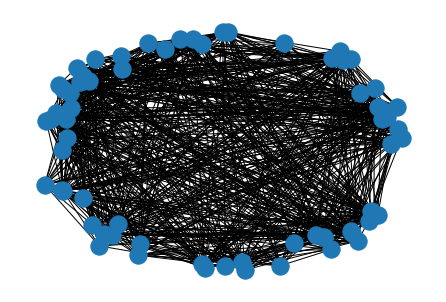

In [740]:
ok = out_select['opt.icov'].copy()
np.fill_diagonal(ok,0)
G = nx.from_numpy_array(ok)
nx.draw(G)
nx.density(G)

0.31614654002713705

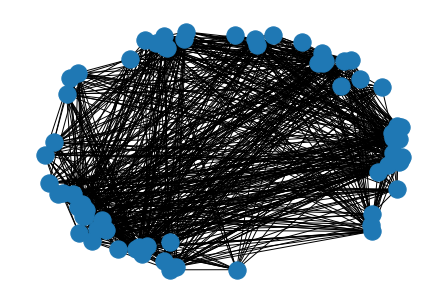

In [749]:
ok = out_select['icov'][opt_index-1].copy()
np.fill_diagonal(ok,0)
G = nx.from_numpy_array(ok)
nx.draw(G)
nx.density(G)

# sklearn glasso

c:\Users\User\Code\MMDGraph\.mmdvenv8\lib\site-packages\numpy\core\_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


array([-9497.79000667, -5672.67667884, -3902.94917592, -1850.46869785,
       -1480.05407468, -1116.19616615,  -797.53669138,  -493.33256637,
          46.1388955 ,   306.93429541,   655.08454244,  1307.29924656,
        1776.51585994,  1819.13072536,  2113.12217376,  2425.87175987,
        2801.11524297,  3378.19006706,  3596.06281377,  4585.53843523])

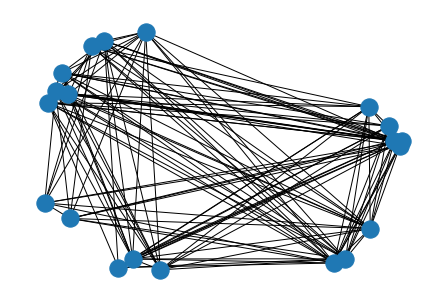

In [350]:
from sklearn.covariance import GraphicalLassoCV
glasso = GraphicalLassoCV(cv = 3).fit(X[:, :20])

ok = glasso.precision_
np.fill_diagonal(ok,0)

nx.draw(nx.from_numpy_array(ok))
l,u = np.linalg.eigh(ok)
l


In [353]:
np.linalg.inv(np.cov(X.T))

array([[33296.54488788,   130.1576352 ,   556.0730679 , ...,
         5024.81927868,  -403.3110298 ,  -702.31223895],
       [  130.1576352 , 21652.80452904, -1702.82786107, ...,
        -2948.24444134, -1182.37042   ,  1515.92449253],
       [  556.0730679 , -1702.82786107, 19018.62701822, ...,
         1241.1691842 ,  -966.59118403, -1193.54552925],
       ...,
       [ 5024.81927868, -2948.24444134,  1241.1691842 , ...,
        19858.81316626,  1358.82496798,   -85.80945303],
       [ -403.3110298 , -1182.37042   ,  -966.59118403, ...,
         1358.82496798, 16919.18151784, -1701.24887848],
       [ -702.31223895,  1515.92449253, -1193.54552925, ...,
          -85.80945303, -1701.24887848, 10023.60085854]])

In [251]:
glasso.cv_results_

c:\Users\User\Code\MMDGraph\.mmdvenv8\lib\site-packages\sklearn\covariance\_graph_lasso.py:88: FutureWarning: Key: 'split0_score', is deprecated in 1.0 and will be removed in 1.2. Use 'split0_test_score' instead
  warnings.warn(
c:\Users\User\Code\MMDGraph\.mmdvenv8\lib\site-packages\sklearn\covariance\_graph_lasso.py:88: FutureWarning: Key: 'split1_score', is deprecated in 1.0 and will be removed in 1.2. Use 'split1_test_score' instead
  warnings.warn(
c:\Users\User\Code\MMDGraph\.mmdvenv8\lib\site-packages\sklearn\covariance\_graph_lasso.py:88: FutureWarning: Key: 'split2_score', is deprecated in 1.0 and will be removed in 1.2. Use 'split2_test_score' instead
  warnings.warn(
c:\Users\User\Code\MMDGraph\.mmdvenv8\lib\site-packages\sklearn\covariance\_graph_lasso.py:88: FutureWarning: Key: 'mean_score', is deprecated in 1.0 and will be removed in 1.2. Use 'mean_test_score' instead
  warnings.warn(
c:\Users\User\Code\MMDGraph\.mmdvenv8\lib\site-packages\sklearn\covariance\_graph_lasso.

{'alphas': array([4.51964974e-04, 9.73729020e-05, 7.16316211e-05, 5.26952473e-05,
        3.87648505e-05, 2.85170620e-05, 2.68187242e-05, 2.52215311e-05,
        2.37194590e-05, 2.23068431e-05, 2.20345802e-05, 2.17656402e-05,
        2.14999828e-05, 2.12375679e-05, 2.09783558e-05, 4.51964974e-06,
        0.00000000e+00]),
 'split0_test_score': array([56.09079256, 59.40679569, 60.81377733, 61.54487643, 61.93829646,
        62.16071445, 62.1904642 , 62.21644787, 62.23847607, 62.25694212,
        62.26024062, 62.26341358, 62.26646318, 62.26939069,        -inf,
               -inf, 61.42955913]),
 'split0_score': array([56.09079256, 59.40679569, 60.81377733, 61.54487643, 61.93829646,
        62.16071445, 62.1904642 , 62.21644787, 62.23847607, 62.25694212,
        62.26024062, 62.26341358, 62.26646318, 62.26939069,        -inf,
               -inf, 61.42955913]),
 'split1_test_score': array([57.84266543, 60.52443283, 61.38003725, 62.01249151, 62.43385801,
        62.70356454, 62.74274605, 6

# GGLasso


In [229]:
from gglasso.problem import glasso_problem
P = glasso_problem(np.cov(X.T), X.shape[0], reg_params = {'lambda1': 0.05}, latent = False, do_scaling = False)

In [235]:
lambda1_range = np.logspace(0, -3, 30)
modelselect_params = {'lambda1_range': lambda1_range}

P.model_selection(modelselect_params = modelselect_params, method = 'eBIC', gamma = 0.1)
P.solution.precision_

array([[10712.72339524,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,  6828.87183737,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,  4521.98943156, ...,
            0.        ,     0.        ,     0.        ],
       ...,
       [    0.        ,     0.        ,     0.        , ...,
         6557.7521005 ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,  6412.8475339 ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,  3884.60172106]])

In [236]:
P.solution.precision_

array([[10712.72339524,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,  6828.87183737,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,  4521.98943156, ...,
            0.        ,     0.        ,     0.        ],
       ...,
       [    0.        ,     0.        ,     0.        , ...,
         6557.7521005 ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,  6412.8475339 ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,  3884.60172106]])

In [237]:
from gglasso.helper.data_generation import generate_precision_matrix, group_power_network, sample_covariance_matrix
from gglasso.problem import glasso_problem
from gglasso.helper.basic_linalg import adjacency_matrix

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

p = 20
N = 1000

Sigma, Theta = generate_precision_matrix(p=p, M=1, style='erdos', prob=0.1, seed=1234)

S, sample = sample_covariance_matrix(Sigma, N)

print("Shape of empirical covariance matrix: ", S.shape)
print("Shape of the sample array: ", sample.shape)

Shape of empirical covariance matrix:  (20, 20)
Shape of the sample array:  (20, 1000)


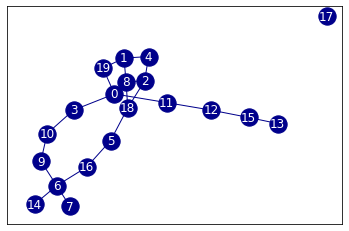

In [238]:
A = adjacency_matrix(Theta)

G = nx.from_numpy_array(A)
pos = nx.drawing.layout.spring_layout(G, seed = 1234)

plt.figure()
nx.draw_networkx(G, pos = pos, node_color = "darkblue", edge_color = "darkblue", font_color = 'white', with_labels = True)

In [239]:
P = glasso_problem(S, N, reg_params = {'lambda1': 0.05}, latent = False, do_scaling = False)
print(P)

 
SINGLE GRAPHICAL LASSO PROBLEM 
Regularization parameters:
{'lambda1': 0.05, 'mu1': None}


In [240]:
lambda1_range = np.logspace(0, -3, 30)
modelselect_params = {'lambda1_range': lambda1_range}

P.model_selection(modelselect_params = modelselect_params, method = 'eBIC', gamma = 0.1)

# regularization parameters are set to the best ones found during model selection
print(P.reg_params)

ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 13 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 9 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 31 iterations with status: optimal.
ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 24 iterations with status: optimal.
ADMM terminated after 9 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 32 iterations with status: optimal.
ADMM terminated after 32 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 37 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminated 

In [241]:
np.linalg.eigh(P.solution.precision_)

(array([0.35032749, 0.51360373, 0.59866797, 0.63364128, 0.84550003,
        0.86330357, 0.88314453, 0.88477144, 0.92308544, 0.97858934,
        0.99189372, 1.02415215, 1.03237539, 1.04370464, 1.11608856,
        1.13912686, 1.33345918, 1.34835067, 1.36309521, 1.44802635]),
 array([[-2.82478716e-03,  2.28333233e-02, -3.28402389e-01,
         -1.49939687e-02,  5.44356253e-01,  1.64315323e-03,
          1.90616186e-01,  1.40512848e-02, -7.47372649e-04,
          1.86486786e-02,  6.81066658e-05, -2.37763805e-05,
          4.74944939e-17,  5.15566535e-04,  6.27413243e-01,
         -1.55048941e-01,  8.74852258e-03, -3.09658490e-01,
         -2.10926236e-01, -6.95450272e-03],
        [-3.22264735e-03,  2.49950078e-01, -1.49287723e-01,
          6.18605373e-01, -7.79739578e-02, -1.76512678e-04,
         -7.79239221e-02, -4.83070286e-03,  2.69941215e-04,
         -2.34602108e-01,  3.28218202e-04, -1.09987010e-02,
          2.17047303e-17, -4.30198603e-05, -5.65737433e-02,
         -1.56519691e-

# asdf

In [441]:
with open(f'../data/Graphs/case_study_1_d_1_winlen_300_gest_huge_glasso_ebic_scale_None.pkl', 'rb') as f:
    data_dict = pickle.load(f)
data_dict[0].keys()

dict_keys(['dates', 'graph_dict', 'sector', 'cov_dict', 'GMV_portfolio_dict', 'max_sharpe_portfolio_dict', 'return_dict', 'window_size', 'stock_partition', 'gmv_div_dict', 'gmv_var_div_dict', 'sharpe_div_dict', 'sharpe_var_div_dict', 'uni_div_dict', 'uni_var_div_dict', 'cov_dict2', 'GMV_portfolio_dict2', 'max_sharpe_portfolio_dict2', 'return_dict2', 'gmv_div_dict2', 'gmv_var_div_dict2', 'sharpe_div_dict2', 'sharpe_var_div_dict2', 'uni_div_dict2', 'uni_var_div_dict2'])

In [447]:
data_dict[0]['max_sharpe_portfolio_dict'][0][0]

array([ -5.56758164,  -0.77659614,   3.3621589 ,  -1.54456253,
       -23.69649873,  -6.97204964,   2.25920047,  -1.30675267,
         5.80657684, -17.15734765,  -0.21540404,   7.38025357,
         7.75586011,  19.91582093,   0.76772217,   1.09881244,
        -0.73068965,  11.71869464,   9.05905117, -10.15666852])

In [450]:
S = data_dict[0]['cov_dict'][0][0]
precision_matrix = np.linalg.inv(S)
mu = data_dict[0]['return_dict'][0][0]
w_sharpe = np.dot(precision_matrix, mu)/np.dot(np.ones(S.shape[0]), precision_matrix).dot(mu)
w_sharpe


array([ -5.56758164,  -0.77659614,   3.3621589 ,  -1.54456253,
       -23.69649873,  -6.97204964,   2.25920047,  -1.30675267,
         5.80657684, -17.15734765,  -0.21540404,   7.38025357,
         7.75586011,  19.91582093,   0.76772217,   1.09881244,
        -0.73068965,  11.71869464,   9.05905117, -10.15666852])

is it correct?

In [604]:
rolling_window_size = 300
time_i = 300
assets = data_dict[0]['stock_partition'][0][0]
current_returns = return_pivot.loc[:,np.isin(return_pivot.columns,assets)].iloc[(time_i - rolling_window_size):time_i]
current_returns = current_returns.iloc[:,:]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
current_return_scaled = scaler.fit_transform(current_returns)

X = np.array(current_returns)
#scaler = StandardScaler()
#X = scaler.fit_transform(X)
#out_heavy_no_constraint = fingraph.learn_regular_heavytail_graph(X, heavy_type = "student", nu = 4, verbose = False)
#out_heavy_no_constraint = dict(zip(out_heavy_no_constraint.names, list(out_heavy_no_constraint)))
#precision_matrix =out_heavy_no_constraint['laplacian']
#precision_matrix = precision_matrix + 0.0001*np.identity(precision_matrix.shape[0])
#S = np.linalg.inv(precision_matrix)

out = huge.huge(np.cov(X.T), method = 'glasso', nlambda = 30,verbose = False)
out_select = huge.huge_select(out, criterion = "ebic", stars_thresh = 0.1, rep_num = 10,ebic_gamma = 0.5 )
out_select = dict(zip(out_select.names, list(out_select)))
precision_matrix = out_select['opt.icov'].copy()
S = np.linalg.inv(precision_matrix)

mu = current_returns.mean()

# GMV diversification
w_gmv = np.dot(precision_matrix, np.ones(S.shape[0]))/np.dot(np.ones(S.shape[0]), precision_matrix).dot(np.ones(S.shape[0])) 
# SHARPE
w_sharpe = np.dot(precision_matrix, mu)/np.dot(np.ones(S.shape[0]), precision_matrix).dot(mu)
w_sharpe

Model selection is not available when using the covariance matrix as input.

KeyError: 'opt.icov'

In [588]:
np.sum(w_sharpe[w_sharpe <0]) <-0.3

False

In [703]:
def fix_weight(w:np.array):

    if np.sum(w[w <0]) <-0.3:

        # fix negative
        w[w <0] = 0.3*w[w <0]/np.abs(np.sum(w[w <0]))
        w[w >=0] = 1.3*w[w >=0]/np.abs(np.sum(w[w >=0]))

    return w


In [704]:
w_new = fix_weight(w_sharpe)
np.sum(w_new)

1.0000000000000004

In [702]:
X

array([[-0.00076647,  0.00146627, -0.0071986 , ...,  0.00091197,
         0.        , -0.00979343],
       [-0.000511  ,  0.00018309,  0.00048167, ..., -0.00592962,
         0.01202942, -0.00249857],
       [ 0.00229779, -0.00477229, -0.01145835, ...,  0.00842758,
        -0.00012991,  0.00733823],
       ...,
       [ 0.00205601,  0.00467346,  0.01355426, ..., -0.00216407,
        -0.00691753,  0.00775609],
       [ 0.00568908,  0.        ,  0.00874976, ...,  0.00270452,
         0.02204863,  0.01934542],
       [-0.01118097, -0.01137383, -0.03546873, ..., -0.00677591,
        -0.02204863, -0.00991485]])

In [707]:
numerator[0]

0.004161780389268643

In [732]:
from statsmodels.distributions.empirical_distribution import ECDF
import scipy.integrate as integrate
ecdf = ECDF(np.dot(X,w_new))

numerator = integrate.quad(lambda x: 1-ecdf(x), 0, np.inf, limit = 10000)
denominator = integrate.quad(ecdf, -np.inf, 0, limit = 10000)

omega_0 = numerator/denominator


TypeError: unsupported operand type(s) for /: 'tuple' and 'tuple'

In [491]:
denominator

(0.00301437657528685, 1.3879408592917808e-08)

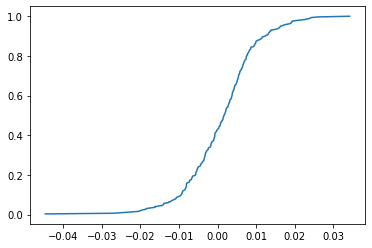

In [478]:
plt.plot(ecdf.x, ecdf.y)

In [481]:
ecdf([0,0.05])

array([0.42666667, 1.        ])

# Test sklearn and hugo

The input is identified as the covariance matrix.
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 100%
Conducting the graphical lasso (glasso)....done.                                          
[0.1]


array([[[ 1.46099210e+00, -1.71801938e-01, -0.00000000e+00,
         -0.00000000e+00, -5.45586772e-02, -4.73665226e-02,
         -1.50530975e-01, -6.01154638e-01, -0.00000000e+00,
         -6.24272462e-02, -0.00000000e+00, -0.00000000e+00,
         -6.34798197e-03, -1.47872593e-02, -0.00000000e+00,
         -3.00456284e-02, -4.78210615e-02, -0.00000000e+00,
         -2.76686867e-02, -0.00000000e+00],
        [-1.71759064e-01,  1.83106020e+00, -2.00755660e-01,
         -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
         -7.34670205e-01, -4.73031984e-02, -1.48178894e-01,
         -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
         -6.04660708e-02, -0.00000000e+00, -9.45238345e-02,
         -1.26808867e-01, -1.13776922e-01, -3.07699448e-02,
         -0.00000000e+00, -3.77772402e-02],
        [-0.00000000e+00, -2.00768931e-01,  1.39859802e+00,
         -2.12728985e-02, -1.49784921e-02, -7.68567387e-02,
         -1.98009308e-01, -1.28342952e-01, -3.50190181e-03,
         -0.

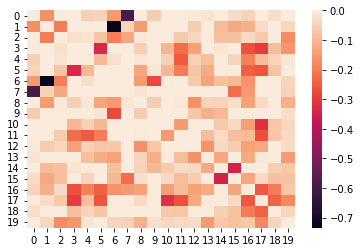

In [603]:
out = huge.huge(np.corrcoef(X.T), 0.1, method = 'glasso',scr = False)
out = dict(zip(out.names, list(out)))
print(out['lambda'])
#out_select = huge.huge_select(out, criterion = "ebic",ebic_gamma = 0.5   )
#out_select = dict(zip(out_select.names, list(out_select)))

ok = np.array(out['icov'][0])
np.fill_diagonal(ok, 0)
sns.heatmap(ok)
np.array(out['icov'])

In [606]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit_transform(X)

out_sklearn2 = GraphicalLassoCV().fit(X)
out_sklearn2.precision_

c:\Users\User\Code\MMDGraph\.mmdvenv8\lib\site-packages\numpy\core\_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


array([[ 1.08455392e+04, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -2.62140544e+02, -7.21199712e+02, -0.00000000e+00,
        -0.00000000e+00, -2.06559393e+02, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00],
       [-0.00000000e+00,  1.06837186e+04, -7.67882577e+02,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -2.64960085e+03, -0.00000000e+00, -3.37827178e+02,
        -0.00000000e+00, -4.07961810e+02, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -1.32293215e+01,
        -3.69253532e+02, -4.50411675e+01, -1.92531108e+02,
        -0.00000000e+00, -0.00000000e+00],
       [-0.00000000e+00, -7.67882577e+02,  6.24595888e+03,
        -2.00426248e+02, -0.00000000e+00, -2.83610054e+02,
        -9.50133789e+02, -1.35422663e+02, -6.76189229e+01,
        -0.00000000e+00, -0.0

In [607]:
out_sklearn = graphical_lasso(np.corrcoef(X.T),alpha = 0.1, mode = 'cd')
out_sklearn[1]

array([[ 1.77172946, -0.22430978, -0.        , -0.        , -0.0635444 ,
        -0.04461222, -0.18357607, -0.82073006, -0.        , -0.06449374,
        -0.        , -0.        , -0.        , -0.00529894, -0.        ,
        -0.01290957, -0.05479672, -0.        , -0.02193544, -0.        ],
       [-0.22430978,  2.35805101, -0.25600503, -0.        , -0.        ,
        -0.        , -1.09943224, -0.02642517, -0.18189671, -0.        ,
        -0.        , -0.        , -0.06259799, -0.        , -0.10365209,
        -0.16405794, -0.13885047, -0.0067961 , -0.        , -0.03427764],
       [-0.        , -0.25600503,  1.64496168, -0.00601636, -0.01118342,
        -0.08743372, -0.24708171, -0.15289559, -0.        , -0.        ,
        -0.        , -0.07705014, -0.04582967, -0.        , -0.09880825,
        -0.09948342, -0.03423863, -0.08295473, -0.        , -0.22737027],
       [-0.        , -0.        , -0.00601636,  2.249439  , -0.        ,
        -0.4601609 , -0.        , -0.        , -

In [507]:
out = huge.huge(X, method = 'glasso', nlambda = 30,verbose = False)
out_select = huge.huge_select(out, criterion = "ebic", stars_thresh = 0.1, rep_num = 10,ebic_gamma = 0.5 )
out_select = dict(zip(out_select.names, list(out_select)))
# precision_matrix = out_select['opt.icov'].copy()
# S = np.linalg.inv(precision_matrix)
out_select['icov']

Conducting extended Bayesian information criterion (ebic) selection....done


<rpy2.robjects.vectors.ListVector object at 0x000001D2CE9EB080> [RTYPES.VECSXP]
R classes: ('list',)
[FloatSexp..., FloatSexp..., FloatSexp..., FloatSexp..., ..., FloatSexp..., FloatSexp..., FloatSexp..., FloatSexp...]
  <no name>: <class 'numpy.ndarray'>
  array([[0.55112807, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.55112807, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.55112807, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.55112807, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.55112807,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.55112807, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.55112807, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.55112807, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.55112807, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.55112807,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.55112807, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.55112807, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.55112807, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.55112807, 0

# My hugo

In [822]:
robjects.r('''

library(huge)

huge.glasso = function(x, lambda = NULL, lambda.min.ratio = NULL, nlambda = NULL, scr = NULL, cov.output = FALSE, verbose = TRUE){

  gcinfo(FALSE)
  n = nrow(x)
  d = ncol(x)
  cov.input = isSymmetric(x)
  if(cov.input)
  {
    if(verbose) cat("The input is identified as the covariance matrix.\n")
    S = x
  }
  else
  {
    print("my_method")
    S = cov(x)
  }
  rm(x)
  gc()
  if(is.null(scr)) scr = FALSE
  if(!is.null(lambda)) nlambda = length(lambda)
  if(is.null(lambda))
  {
    if(is.null(nlambda))
      nlambda = 10
    if(is.null(lambda.min.ratio))
      lambda.min.ratio = 0.1
    lambda.max = max(max(S-diag(d)),-min(S-diag(d)))
    lambda.min = lambda.min.ratio*lambda.max
    lambda = exp(seq(log(lambda.max), log(lambda.min), length = nlambda))
  }

  fit = .Call("_huge_hugeglasso",S,lambda,scr,verbose,cov.output,PACKAGE="huge")

  fit$scr = scr
  fit$lambda = lambda
  fit$cov.input = cov.input
  fit$cov.output = cov.output

  rm(S)
  gc()
  if(verbose){
       cat("\nConducting the graphical lasso (glasso)....done.                                          \r")
       cat("\n")
      flush.console()
  }
  return(fit)
}

huge = function(x, lambda = NULL, nlambda = NULL, lambda.min.ratio = NULL, method = "mb", scr = NULL, scr.num = NULL, cov.output = FALSE, sym = "or", verbose = TRUE)
{
	gcinfo(FALSE)
	est = list()
	est$method = method

	if(method == "ct")
	{
		fit = huge.ct(x, nlambda = nlambda, lambda.min.ratio = lambda.min.ratio, lambda = lambda, verbose = verbose)
		est$path = fit$path
		est$lambda = fit$lambda
		est$sparsity = fit$sparsity
		est$cov.input = fit$cov.input
		rm(fit)
		gc()
	}

	if(method == "mb")
	{
		fit = huge.mb(x, lambda = lambda, nlambda = nlambda, lambda.min.ratio = lambda.min.ratio, scr = scr, scr.num = scr.num, sym = sym, verbose = verbose)
		est$path = fit$path
		est$beta = fit$beta
		est$lambda = fit$lambda
		est$sparsity = fit$sparsity
		est$df = fit$df
		est$idx_mat = fit$idx_mat
		est$sym = sym
		est$scr = fit$scr
		est$cov.input = fit$cov.input
		rm(fit,sym)
		gc()
	}


	if(method == "glasso")
	{
		fit = huge.glasso(x, nlambda = nlambda, lambda.min.ratio = lambda.min.ratio, lambda = lambda, scr = scr, cov.output = cov.output, verbose = verbose)
		est$path = fit$path
		est$lambda = fit$lambda
		est$icov = fit$icov
		est$df = fit$df
		est$sparsity = fit$sparsity
		est$loglik = fit$loglik
		if(cov.output)
			est$cov = fit$cov
		est$cov.input = fit$cov.input
		est$cov.output = fit$cov.output
		est$scr = fit$scr
		rm(fit)
		gc()
	}

	if(method == "tiger")
	{
	  fit = huge.tiger(x, lambda = lambda, nlambda = nlambda, lambda.min.ratio = lambda.min.ratio, sym = sym, verbose = verbose)
	  est$path = fit$path
	  est$lambda = fit$lambda
	  est$sparsity = fit$sparsity
	  est$df = fit$df
	  est$idx_mat = fit$idx_mat
	  est$sym = sym
	  est$scr = fit$scr
	  est$cov.input = fit$cov.input
	  est$icov = fit$icov;
	  rm(fit,sym)
	  gc()
	}

	est$data = x

	rm(x,scr,lambda,lambda.min.ratio,nlambda,cov.output,verbose)
	gc()
	class(est) = "huge"
	return(est)
}

my_huge <- function(X, gamma = 0.1){

    out.glasso = huge(X, lambda = exp(seq(log(1e-5), log(1e-7), length = 30)), method = "glasso")
    return(huge.select(out.glasso, criterion = "ebic",ebic.gamma = 0.1 ))


}


''')

<rpy2.robjects.functions.SignatureTranslatedFunction object at 0x000001D2E841FC40> [RTYPES.CLOSXP]
R classes: ('function',)

In [840]:
my_huge = robjects.globalenv["my_huge"]
out_select = my_huge(X, gamma = 0.01)
out_select = dict(zip(out_select.names, list(out_select)))

[1] "my_method"
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 3%6%9%13%16%19%23%26%30%33%36%40%43%46%50%53%56%60%63%66%70%73%76%80%83%86%90%93%96%100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting extended Bayesian information criterion (ebic) selection....done


In [841]:
out_select.keys()

dict_keys(['method', 'path', 'lambda', 'icov', 'df', 'sparsity', 'loglik', 'cov.input', 'cov.output', 'scr', 'data', 'ebic.score', 'opt.index', 'refit', 'opt.icov', 'opt.lambda', 'opt.sparsity', 'criterion'])

In [842]:
type(int(np.where(out_select['opt.lambda'][0] == out_select['lambda'])[0][0]))

int

In [843]:
precision_matrix = out_select['opt.icov'].copy()
precision_matrix

array([[15916.21686681,    -0.        ,    -0.        , ...,
           -0.        ,    -0.        ,   -69.04022721],
       [   -0.        , 13129.60175936,  -282.06224506, ...,
        -1173.50102862,    -0.        ,    -0.        ],
       [   -0.        ,  -281.90624567, 10906.64767395, ...,
           -0.        ,  -242.08621   ,    -0.        ],
       ...,
       [   -0.        , -1173.51916192,    -0.        , ...,
        11432.8908519 ,    -0.        ,    -0.        ],
       [   -0.        ,    -0.        ,  -242.1685583 , ...,
           -0.        , 10283.44657355,  -526.63345583],
       [  -69.07869588,    -0.        ,    -0.        , ...,
           -0.        ,  -526.60394165,  6579.71306227]])

In [844]:
S = np.linalg.inv(precision_matrix)
S

array([[1.03344144e-04, 4.80044697e-05, 5.79364214e-05, ...,
        4.47700384e-05, 3.93414779e-05, 5.84762617e-05],
       [4.80073192e-05, 1.56433106e-04, 9.90411513e-05, ...,
        8.17314060e-05, 6.09543422e-05, 8.86464300e-05],
       [5.79572504e-05, 9.90691242e-05, 2.31171785e-04, ...,
        9.49057067e-05, 8.00653612e-05, 1.11942353e-04],
       ...,
       [4.47781962e-05, 8.17415682e-05, 9.48913195e-05, ...,
        1.62498227e-04, 5.73198225e-05, 8.30056194e-05],
       [3.93497291e-05, 6.09649070e-05, 8.00557037e-05, ...,
        5.73214717e-05, 1.65943376e-04, 8.62510595e-05],
       [5.84903559e-05, 8.86643054e-05, 1.11930539e-04, ...,
        8.30111035e-05, 8.62525964e-05, 2.67441777e-04]])